<a href="https://colab.research.google.com/github/ilanmoshe52/Final_Project/blob/main/Alzheimers_Dataset__CNN_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> **Deep Learning Final work** </center>
## <center> **Convolutional Neural Network**</center>
### <center> **Ilan Moshe 024176398** </center>






.

Introduction:

Alzheimer's disease is a progressive neurodegenerative disorder that primarily affects memory, thinking skills, and behavior. It is the most common form of dementia, accounting for a significant proportion of cases worldwide. Early detection and accurate classification of Alzheimer's disease play a vital role in improving patient outcomes, providing appropriate care, and facilitating the development of potential treatments. In recent years, there has been increasing interest in leveraging advanced technologies, such as machine learning and artificial intelligence, for the detection and classification of Alzheimer's disease.

Significance and Benefits:

The development of robust algorithms for Alzheimer's detection and classification has significant significance and benefits. Firstly, early diagnosis allows for early intervention, which can potentially slow down the progression of the disease and improve the quality of life for affected individuals. It provides an opportunity for timely medical intervention and the implementation of personalized treatment plans tailored to the individual's needs. Additionally, accurate classification of Alzheimer's disease aids in distinguishing it from other forms of dementia, enabling more precise prognosis and appropriate management strategies.

Furthermore, the ability to detect and classify Alzheimer's disease accurately can aid in the development of new therapeutic approaches. By identifying biomarkers and patterns associated with the disease, researchers can gain a better understanding of its underlying mechanisms and potentially discover new targets for drug development. Moreover, it can assist in the selection of appropriate participants for clinical trials, leading to more efficient and targeted studies aimed at finding effective treatments and prevention strategies.

Prior Research and Work:

The field of Alzheimer's detection and classification has witnessed significant advancements in recent years, driven by the availability of large-scale datasets and advancements in machine learning techniques. Several prior studies have focused on utilizing various modalities for accurate diagnosis, such as neuroimaging data (e.g., MRI, PET scans), cognitive assessments, and genetic markers.

For instance, researchers have explored the potential of machine learning algorithms to analyze neuroimaging data and identify specific patterns indicative of Alzheimer's disease. These studies have demonstrated promising results in distinguishing between Alzheimer's patients and healthy individuals, as well as predicting disease progression. Additionally, efforts have been made to incorporate other data sources, including clinical information and biomarkers, to enhance classification accuracy and robustness.

While these previous works have laid the foundation for Alzheimer's detection and classification, there is still room for improvement. Challenges remain, including the need for more diverse and representative datasets, the development of interpretable models, and the integration of multimodal data for comprehensive analysis. Building upon this prior research, we aim to contribute to the field by developing novel algorithms that improve accuracy, efficiency, and interpretability in Alzheimer's detection and classification.

In summary, the significance of Alzheimer's detection and classification lies in its potential to enable early intervention, improve patient outcomes, guide treatment strategies, and facilitate the development of effective therapies. By leveraging previous research and incorporating advancements in machine learning, our work aims to advance the field and contribute to the collective effort of combating this debilitating disease.

# General Operations

##### General Instructions:
1. Run Only on Colab
2. Updaload two zip files ( The program will unzip then to the correct location)

#### Generl Settings

In [ ]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

#google colab pip
if 'google.colab' in str(get_ipython()):
    !pip install torchinfo

%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### imports

In [ ]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import time
import os
import torchvision
import torch.nn            as nn
import torch.optim         as optim
import torchinfo
import zipfile
import torchvision.transforms as transforms
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix , classification_report
import warnings

warnings.filterwarnings('ignore')
matplotlib.rc('font', **{'size' : 16})
os.environ["TZ"] = "US/Eastern"
time.tzset()

#### consts


In [ ]:
data_path = '/content/Dataset/Dataset/'
validation_data_path = '/content/Dataset/test'
file_type = 'jpg'

# Datasets load and extraction of files

### Since the original dataset in the link wasnt good enough for classication I have found two datasets on kaggle.

*   One dataset is used for training and testing (MRI_Dataset.zip)
*   The scond one is used for the prediction after we have our model (Val_Dataset.zip)

Both dataset should be uploaded to the Colab notebook prior to running and it will continue asking for them until they are loaded.

(I have a sych problem with my google drive that is why I coose this solution because I want the notebook to be ran with these datasets only)

In [ ]:
IsDataLoaded = False
while not (IsDataLoaded):
  try:
    with zipfile.ZipFile('/content/MRI_Dataset.zip', 'r') as zipObj:
        zipObj.extractall('/content/Dataset')
    IsDataLoaded = True
  except:
      print('Please upload train dataset zip file ')
      time.sleep(10)

IsDataLoaded = False
while not (IsDataLoaded):
  try:
    with zipfile.ZipFile('/content/Val_Dataset.zip', 'r') as zipObj:
        zipObj.extractall('/content/Dataset')
    IsDataLoaded = True
  except:
      print('Please upload test dataset zip file ')
      time.sleep(10)


print('Train and Validation DataSets are ready')


Train and Validation DataSets are ready


# Model funtion Definitions

##### calculate Accuracy

In [ ]:
# Accuracy calculation function
def Accuracy(mScore, vY):
    vHatY = mScore.detach().argmax(dim=1)
    return (vHatY == vY).float().mean().item()


##### Handles traninig process

In [ ]:
#handles training process
def TrainClassficationModel(oModel, oTrainData, oValData, Loss, nEpochs, oOptim):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainAcc  = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValAcc    = np.full(nEpochs, np.nan)
    bestAcc    = 0

    for epoch in range(nEpochs):
        startTime = time.time()
        trainLoss, trainAcc = Epoch(oModel, oTrainData, Loss, Accuracy, oOptim, bTrain=True ) #-- train
        valLoss,   valAcc   = Epoch(oModel, oValData,   Loss, Accuracy, None,   bTrain=False) #-- validate
        epochTime = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :03d}:',   end='')
        print(' | Train loss: '     f'{trainLoss:6.3f}',   end='')
        print(' | Val loss: '       f'{valLoss  :6.3f}',   end='')
        print(' | Train Accuracy: ' f'{trainAcc :6.3f}',   end='')
        print(' | Val Accuracy: '   f'{valAcc   :6.3f}',   end='')
        print(' | epoch time: '     f'{epochTime:6.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainAcc [epoch] = trainAcc
        vValLoss  [epoch] = valLoss
        vValAcc   [epoch] = valAcc

        #-- Save best model (early stopping):
        if bestAcc < valAcc:
            bestAcc = valAcc
            dCheckpoint = {'Model' : oModel.state_dict(),
                           'Optim' : oOptim.state_dict()}
            torch.save(dCheckpoint, 'BestModel.pt')
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    dCheckpoint = torch.load('BestModel.pt')
    oModel.load_state_dict(dCheckpoint['Model'])

    return vTrainLoss, vTrainAcc, vValLoss, vValAcc


##### handles a single epoch process

In [ ]:
# handles a single epoch process
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)

        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mZ   = oModel(mX)
            loss = Loss(mZ, vY)
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mZ   = oModel(mX)
                loss = Loss(mZ, vY)

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters

        Nb           = vY.shape[0]
        count       += Nb
        epochLoss   += Nb * loss.item()
        epochMetric += Nb * Metric(mZ, vY)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric


##### Plot the loss and accuracy graphs of the model

In [ ]:
# PlotHistory of entire training function
def PlotHistory(lHistory):

    vTrainLoss, vTrainAcc, vValLoss, vValAcc = lHistory

    plt.figure(figsize=(16, 6))

    plt.subplot(1,2,1)
    plt.plot   (vTrainLoss, 'b', lw=2, label='Train'     )
    plt.plot   (vValLoss,   'r', lw=2, label='Validation')
    plt.title  ('Loss')
    plt.xlabel ('epoch')
    plt.ylim   (bottom=0)
    plt.legend ()
    plt.grid   ()

    plt.subplot(1,2,2)
    plt.plot   (vTrainAcc, 'b', lw=2, label='Train'     )
    plt.plot   (vValAcc,   'r', lw=2, label='Validation')
    plt.title  ('Accuracy')
    plt.xlabel ('epoch')
    plt.ylim   (top=1)
    plt.legend ()
    plt.grid   ()

##### calculates the return vector from the model

In [ ]:
# calculates the return vector from the model
def MySoftmax(x):
  res = []
  samples = x.shape[0]
  for i in range(0,samples):
    max_value = max(x[i])
    max_index = (x[i]).tolist().index(max_value)
    res.append(max_index)

  return res

# Dataset handling

About this Dataset
Alzheimer MRI Preprocessed Dataset (128 x 128)

The Data is downloaded from https://www.kaggle.com/code/bharathkumarmatta/cnn-transfer-dl-project/input.

The Dataset is consists of Preprocessed MRI (Magnetic Resonance Imaging) Images.
All the images are resized into 128 x 128 pixels.
The Dataset has four classes of images.
The Dataset is consists of total 6400 MRI images. \n


*   Class - 1: Mild Demented (896 images)
*   Class - 2: Moderate Demented (64 images)
*   Class - 3: Non Demented (3200 images)
*   Class - 4: Very Mild Demented (2240 images)

I have created two files for the process:


*   MRI_Dataset.zip - the dataset used for training and testing dataset
*   Val_Dataset.zip - a separate validation dataset used for predictions

These files must be loaded to the site in order for the program start running




In [ ]:
# Define the transformation to be applied to each image
transform_n = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a fixed size
    transforms.ToTensor(),          # Convert images to tensors
])

# load the data
oTrainSet = torchvision.datasets.DatasetFolder(root=data_path ,
                                               loader=torchvision.datasets.folder.default_loader,
                                               extensions= file_type,
                                               transform=transform_n)



#### Plot dataset classes and number of each class

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


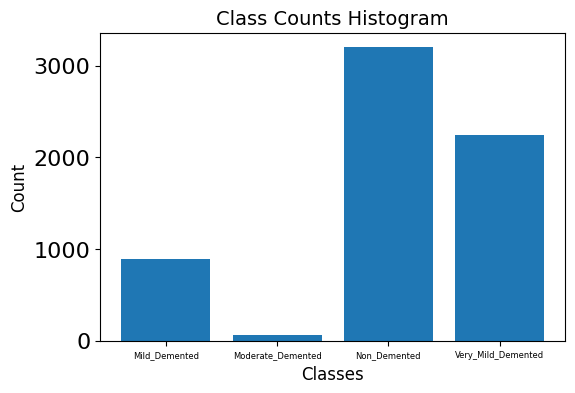

In [ ]:
# print classes of datasets
lClasses  = oTrainSet.classes
print(lClasses)

# Count the number of targets for each class
class_counts = {}
for _, target in oTrainSet:
    class_counts[target] = class_counts.get(target, 0) + 1

x_labels = lClasses
y_counts = list(class_counts.values())

# Plot the histogram
plt.figure(figsize = (6,4))
plt.bar(x_labels, y_counts  )
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Class Counts Histogram', fontsize=14)
plt.tick_params(axis='x', labelsize=6)
plt.show()

### We can see that the dataset is not balanced between class ( There are only few items in "Moderate Demention" class but almost 3000 items for other classes) . This is not a recomended state for recieveing a good balanced model

#### Plot some examples:

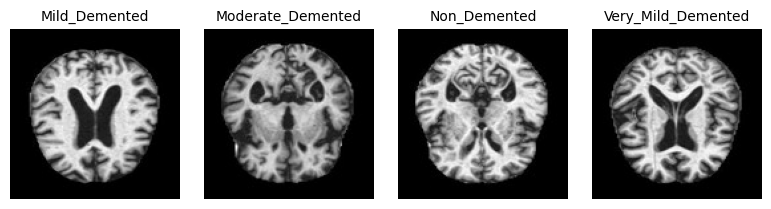

In [ ]:
fig, _  = plt.subplots(1, 4, figsize=(8,20))
idx = [0 ,900 , 1000,5000]
counter = 0
for ax  in fig.axes:
    mX, y =  oTrainSet[idx[counter]]
    ax.imshow   (mX[0], cmap='gray')
    ax.set_title(f'{lClasses[y]}' , fontsize = 10)
    ax.axis     (False)
    counter+=1
plt.tight_layout()
plt.show        ()

#### Compute mean and variance:

In [ ]:
mean1 = 0
std1 = 0
num = len(oTrainSet)
for i in range(num):
  mX, y = oTrainSet[i]
  image_array = np.array(mX)
  mean1 += np.mean(image_array)
  std1 += np.std(image_array)

mean_f = torch.tensor(mean1/num)
std_f = torch.tensor(std1/num)

print('µ =', mean_f)
print('σ =', std_f)
print('number of images :' ,num)


µ = tensor(0.2786, dtype=torch.float64)
σ = tensor(0.3244, dtype=torch.float64)
number of images : 6400


#### Set datasets with normalization:

In [ ]:
oTransform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor (),
    transforms.Normalize(torch.tensor(mean_f),torch.tensor(std_f))
])

oTrainSet.transform = oTransform

# split the data into train and test subsets
train_idx, val_idx = train_test_split(list(range(len(oTrainSet))), test_size=0.2, random_state = 200)
datasets1 = {}
datasets1['train'] = Subset(oTrainSet, train_idx)
datasets1['test'] = Subset(oTrainSet, val_idx)


# Modle definition and Training

#### This is the main section. We define two dataloades for training and testing , then we define the model and perform the training. All of these will be exaplied along the code execution path

#### We define two dataloders for the training and testing

In [ ]:
batchSize = 8
oTrainDL  = torch.utils.data.DataLoader(datasets1['train'], shuffle=True,  batch_size=batchSize,  num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(datasets1['test'],  shuffle=False,  batch_size= batchSize, num_workers=2, persistent_workers=True)
mX,       vY       = next(iter(oTrainDL))
print(mX.shape, vY.shape)

mX1,       vY1       = next(iter(oTestDL))
print(mX1.shape, vY1.shape)

torch.Size([8, 3, 128, 128]) torch.Size([8])
torch.Size([8, 3, 128, 128]) torch.Size([8])


#### Define the model (2D CNN):
The input data to the model are images with the size of 128*128. We increase the number of channles , and reduced the filter size to create as a large variante of features.Then we define linear layers with decreasing number of nurons until we reach the number of classes of the dataset(4). The model has relativly low amount of weights so it is not very computation intensive.

In [ ]:
def GetModel():
    oModel = nn.Sequential(

        nn.Identity(),
        nn.Conv2d(3,   32,  7, bias=True, padding=3 , stride =2 ),  nn.BatchNorm2d(32),  nn.ReLU(),
        nn.Conv2d(32,  64,  5, bias=True, padding=2 , stride =2 ),  nn.BatchNorm2d(64),  nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(64,  128, 3, bias=True, padding=1,  stride =2 ),  nn.BatchNorm2d(128), nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(128, 256, 3, bias=True, padding=1 , stride =2 ),  nn.BatchNorm2d(256), nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(256,128),  nn.ReLU() ,
        nn.Linear(128,64),   nn.ReLU() , nn.Dropout(0.1),
        nn.Linear(64,4),     nn.ReLU()
     )

    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchinfo.summary(GetModel(), mX.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [8, 4]                    --
├─Identity: 1-1                          [8, 3, 128, 128]          --
├─Conv2d: 1-2                            [8, 32, 64, 64]           4,736
├─BatchNorm2d: 1-3                       [8, 32, 64, 64]           64
├─ReLU: 1-4                              [8, 32, 64, 64]           --
├─Conv2d: 1-5                            [8, 64, 32, 32]           51,264
├─BatchNorm2d: 1-6                       [8, 64, 32, 32]           128
├─ReLU: 1-7                              [8, 64, 32, 32]           --
├─Dropout2d: 1-8                         [8, 64, 32, 32]           --
├─Conv2d: 1-9                            [8, 128, 16, 16]          73,856
├─BatchNorm2d: 1-10                      [8, 128, 16, 16]          256
├─ReLU: 1-11                             [8, 128, 16, 16]          --
├─Dropout2d: 1-12                        [8, 128, 16, 16]          --
├─

#### Check whether GPU is available:

# Train the model

In [ ]:
# check if the device is cpu or gpu
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

#### Train the model:
For model training I have selected crossEntropy Loss funtion and SGD optimizer with learning rate of 0.001 and momentum =0.9. I saw that these parameter gave me the best performance and the model converged in less epochs.

In [ ]:
# train the model
Loss    = nn.CrossEntropyLoss()
nEpochs = 50

oModel   = GetModel               ().to(DEVICE)
oOptim   = optim.SGD(oModel.parameters() , lr=1e-3, momentum=0.9)
lHistory = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim)

Epoch 000: | Train loss:  1.124 | Val loss:  1.037 | Train Accuracy:  0.490 | Val Accuracy:  0.516 | epoch time:  9.878 | <-- Checkpoint!
Epoch 001: | Train loss:  1.026 | Val loss:  0.989 | Train Accuracy:  0.533 | Val Accuracy:  0.552 | epoch time:  9.890 | <-- Checkpoint!
Epoch 002: | Train loss:  1.006 | Val loss:  0.990 | Train Accuracy:  0.544 | Val Accuracy:  0.573 | epoch time:  8.889 | <-- Checkpoint!
Epoch 003: | Train loss:  0.998 | Val loss:  0.946 | Train Accuracy:  0.558 | Val Accuracy:  0.559 | epoch time:  9.731 |
Epoch 004: | Train loss:  0.994 | Val loss:  0.953 | Train Accuracy:  0.543 | Val Accuracy:  0.570 | epoch time:  9.949 |
Epoch 005: | Train loss:  0.977 | Val loss:  0.951 | Train Accuracy:  0.554 | Val Accuracy:  0.582 | epoch time: 10.467 | <-- Checkpoint!
Epoch 006: | Train loss:  0.967 | Val loss:  0.917 | Train Accuracy:  0.560 | Val Accuracy:  0.566 | epoch time: 10.628 |
Epoch 007: | Train loss:  0.951 | Val loss:  1.155 | Train Accuracy:  0.572 | Val 

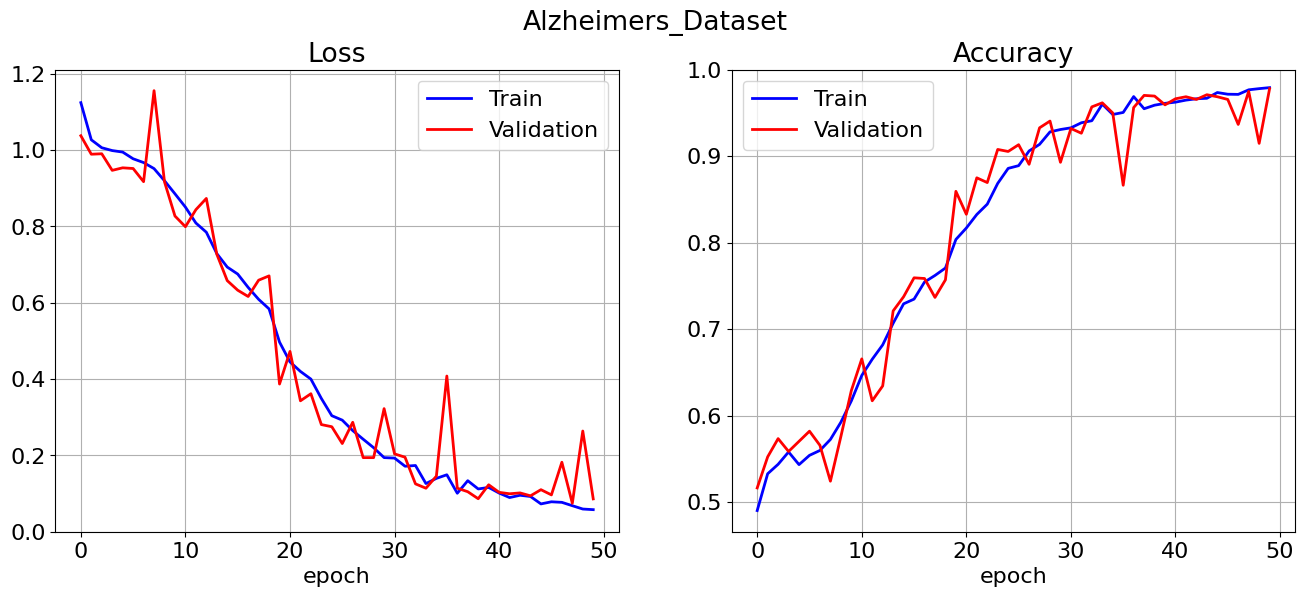

In [ ]:
#from DeepLearningFramework_Solution.Utils import PlotHistory#
PlotHistory (lHistory)
plt.suptitle('Alzheimers_Dataset')
plt.show    ()

### Conclusion :


*   We can see that both loss adn accuracy for training and testing are very close for the entier training process with no overfit or underfit seen. This implies for very robust model with very reliable predictions.
*   The accuracy score is nearly perfect and its value is asmost 98% for both training and validation


# Make Predictions

#### In this section we test our model.
We created a validation dataset for this purpose and we will randomly pick images from this dataset and let the model classifiy them and then verifiy that they we correctly classified , displaying the results in the classification report and a confution matrix

In [ ]:
# load images from the validation dataset
oValSet = torchvision.datasets.DatasetFolder(root=validation_data_path ,
                                               loader=torchvision.datasets.folder.default_loader,
                                               extensions= file_type,
                                               transform=oTransform)


#### Choose 50 images randomally for prediction for the Validation Dataset

In [ ]:
# choose randomally 50 images
size = len(oValSet)
set_size = 50
tests = np.ndarray((set_size,3,128,128), dtype='float32')
true_classes = [0]*set_size
for i in range(0,set_size):
  idx = np.random.randint(0,size)
  mXX, y =  oValSet[idx]
  tests[i] = mXX
  true_classes[i] = y

t = torch.from_numpy(tests)
t.shape

torch.Size([50, 3, 128, 128])

### Example from the images picked for prediction

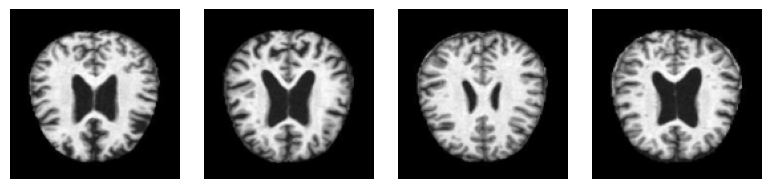

In [ ]:
fig, _  = plt.subplots(1, 4, figsize=(8,8))
counter = 0
for ax  in fig.axes:
    idx = np.random.randint(0,set_size)
    mX =  t[idx]
    ax.imshow   (mX[0], cmap='gray')
    ax.axis     (False)
    counter+=1
plt.tight_layout()
plt.show        ()

##### Execute the validation images with the model and get the results

In [ ]:
# execute the items on the model
with torch.no_grad():
    vHatTestF = oModel(t.to(DEVICE))#.squeeze()
vHatTestF = vHatTestF.detach().cpu() #-- move to CPU

In [ ]:
# results values from the model
output = MySoftmax(vHatTestF.numpy())


##### Print the classification report and the confusion matrix

In [ ]:
# print classification_report
print(classification_report(true_classes, output))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        14

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



<Axes: >

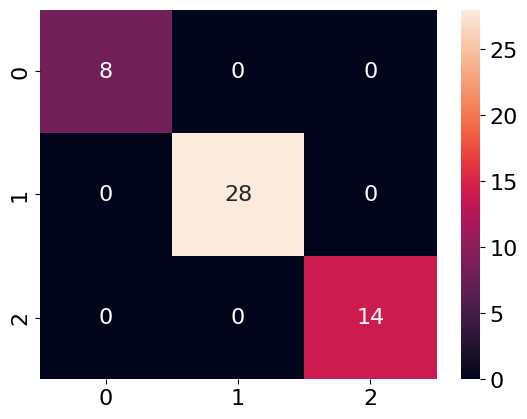

In [ ]:
# print confusion matrix and heatmap
cfg = confusion_matrix(true_classes, output)
sns.heatmap(cfg, annot=True )

**We see that the prdediction results are usually very food with very few  missmatches. Most of the predictions are usually on the main diagonal of the confusion matrix with few misses.**

#Finilize

Project Summary:

In this project, my aim was to develop robust CNN Model for the detection and classification of Alzheimer's disease using advanced deep learning techniques. We recognized the significance of early diagnosis and accurate classification in improving patient outcomes, guiding treatment strategies.

Throughout the project, I have learned that deep learning Modles can effectively analyze various data modalities, to identify patterns indicative of Alzheimer's disease. I observed promising results in terms of classification accuracy and the ability to predict disease progression. These findings further supported the potential of leveraging advanced technologies for Alzheimer's detection and classification.

However, our work also highlighted some limitations and failure cases. One of the main challenges we encountered was the availability of diverse and representative datasets. Limited data diversity can lead to biased models and reduced generalizability, hindering the performance of our algorithms. **This is why I have added two dataset files as part of my model.**

Another issue that could be done is performing Hyper parametrs testing off all free parameters on the model and find the best parameters that will cause the model training to converge quickly.
I didnt do it because with the parametes I have choosen the model converged quickly ( les the 30 epocs to 90% accuracy) , but further reserch can be done on this issue.

Another issue that can be done is to comapre the results of deep learning model to results from the machine learning models such as SVM , descision trees and to compare the results to the results I have recieved with y model it terms of computation requiements and model algorithem performane for classification results.

If we had more time and resources, we would continue and expand upon our work by implementing these improvements. We would focus on acquiring larger and more diverse datasets, develop novel interpretability techniques, and explore the integration of multimodal data. Additionally, we would conduct longitudinal studies to assess the long-term effectiveness of our algorithms and further refine them based on real-world feedback and validation.

In conclusion, our project highlighted the potential of deep learning algorithms for Alzheimer's detection and classification. Expanding upon my work would contribute to advancing the field and ultimately lead to better outcomes for individuals affected by Alzheimer's disease.